# Project: Wrangling and Analyze Data
### WeRateDog
Markus Sobotta \
06-05-2022 \
https://github.com/tien-duong115/Twitter_doggo_page_analysis

## Table of Contents

- [Data Gathering](#Data_Gathering)
- [Assessing Data](#Assessing_Data)
- [Cleaning Data](#Cleaning_Data)
- [Storing Data](#Storing_Data)
- [Analyzing and Visualizing Data](#Analyzing_and_Visualizing_Data)

In [1]:
# Installing the needed package
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import re
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from requests_oauthlib import OAuth1Session
import os
%matplotlib inline

## Data Gathering <a id='Data_Gathering'></a>
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)
2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)
3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [2]:
# 1. 
# Reading in the twitter archives file into pandas dataframe
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive = twitter_archive.sort_values(by=['tweet_id']) # also archive

In [3]:
# 2. 
# Using open and request to open the image-predictions file in tsv.
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
with open('image-predictions.tsv', 'wb') as file:
    image = requests.get(url)
    file.write(image.content)
# Read the tsv file into pandas dataframe
image_prediction = pd.read_csv('image-predictions.tsv', delim_whitespace=True) 
image_prediction = image_prediction.sort_values(by=['tweet_id']) # also image

In [4]:
3. 
# Using twitter_archive tweet id to query line by line into a dictionary
id_list = twitter_archive['tweet_id'].tolist()
id_list = list(dict.fromkeys(id_list))

# delete keys later! 
consumer_key = '***'
consumer_secret = '***'
access_token = '***'
access_secret = '***'

In [5]:
# https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/main/Tweet-Lookup/get_tweets_with_user_context.py
def get_json_file(id_list_input):
    # You can adjust ids to include a single Tweets
    # Or you can add to up to 100 comma-separated IDs
    id_list_str = ','.join(str(e) for e in id_list_input)
    params = {"ids": id_list_str, "tweet.fields": "public_metrics"}
    # Tweet fields are adjustable.
    # Options include:
    # attachments, author_id, context_annotations,
    # conversation_id, created_at, entities, geo, id,
    # in_reply_to_user_id, lang, non_public_metrics, organic_metrics,
    # possibly_sensitive, promoted_metrics, public_metrics, referenced_tweets,
    # source, text, and withheld

    # Make the request
    oauth = OAuth1Session(
        consumer_key,
        client_secret=consumer_secret,
        resource_owner_key=access_token,
        resource_owner_secret=access_secret,
    )

    response = oauth.get(
        "https://api.twitter.com/2/tweets", params=params
    )

    if response.status_code != 200:
        raise Exception(
            "Request returned an error: {} {}".format(response.status_code, response.text)
        )

    #print("Response code: {}".format(response.status_code))
    json_response = response.json()
    #print(json.dumps(json_response, indent=4, sort_keys=True))
    return json.dumps(json_response, indent=4, sort_keys=True)


In [6]:
if False: # so that the twitter API is not called again and again when all cells are executed.
    result = []
    for i in range(0, len(id_list), 100):
        bigger_index = (i+99 if i+99 < len(id_list) else len(id_list))
        part_id_list = id_list[i:bigger_index]
        #print(str(i) + "\t" + str(bigger_index))
        json_file = get_json_file(part_id_list)
        data = json.loads(json_file)
        result.extend(data['data'])

    #print(result)
    json.dump(result, open('tweet_json.txt', 'w'))

In [7]:
with open('tweet_json.txt') as input_file:
    json_file = json.loads(input_file.read())

id_list,like_count_list, retweet_count_list = [],[],[]
for result in json_file:
    id_list.append(result['id'])
    like_count_list.append(result['public_metrics']['like_count'])
    retweet_count_list.append(result['public_metrics']['retweet_count'])

retweet_favorite = pd.DataFrame([id_list,retweet_count_list,like_count_list]).T 
retweet_favorite.columns = ['tweet_id', 'retweet_count', 'favorite_count']
retweet_favorite = retweet_favorite.sort_values(by=['tweet_id']) # auch favorites

## Assessing Data <a id='Assessing_Data'></a>
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.

Helping functions: 
- testing.assert_series_equal
- Various methods of indexing and selecting data - .loc(), .iloc()
- .duplicated()
- .isnull()
- .nunique()
- .info()
- .describe()
- .value_counts()
- .head()
- .tail()
- .sample()

### Visual assessment

In [8]:
# Image prediction
image_prediction.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1216,743545585370791937,https://pbs.twimg.com/media/ClGawiUWAAAgs0w.jpg,2,rapeseed,0.876875,False,standard_poodle,0.060583,True,Great_Pyrenees,0.033006,True
1897,850380195714523136,https://pbs.twimg.com/ext_tw_video_thumb/85038...,1,Yorkshire_terrier,0.249012,True,Maltese_dog,0.166364,True,Shih-Tzu,0.142254,True
1457,777684233540206592,https://pbs.twimg.com/media/CsrjryzWgAAZY00.jpg,1,cocker_spaniel,0.253442,True,golden_retriever,0.162850,True,otterhound,0.110921,True
112,667911425562669056,https://pbs.twimg.com/media/CUTl5m1WUAAabZG.jpg,1,frilled_lizard,0.257695,False,ox,0.235160,False,triceratops,0.085317,False
136,668507509523615744,https://pbs.twimg.com/media/CUcECBYWcAAzFRg.jpg,1,basenji,0.055379,True,Shetland_sheepdog,0.054322,True,whippet,0.051913,True
183,669353438988365824,https://pbs.twimg.com/media/CUoFZTyW4AE70iD.jpg,1,teddy,0.379656,False,Pembroke,0.212343,True,chow,0.096995,True
613,680145970311643136,https://pbs.twimg.com/media/CXBdJxLUsAAWql2.jpg,1,miniature_poodle,0.457117,True,toy_poodle,0.226481,True,Maltese_dog,0.067682,True
1234,746369468511756288,https://pbs.twimg.com/media/ClujESVXEAA4uH8.jpg,1,German_shepherd,0.622957,True,malinois,0.338884,True,wallaby,0.024161,False
1385,766008592277377025,https://pbs.twimg.com/media/CqFouXOXYAAYpzG.jpg,1,Welsh_springer_spaniel,0.728153,True,basset,0.103842,True,Brittany_spaniel,0.062414,True
725,686050296934563840,https://pbs.twimg.com/media/CYVXBb9WsAAwL3p.jpg,1,Pomeranian,0.985789,True,keeshond,0.004083,True,Pekinese,0.003334,True


In [9]:
# twitter archive
twitter_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
929,754482103782404096,NaN,NaN,2016-07-17 01:05:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Milo. He's currently plotting his reve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/754482103...,10,10,Milo,None,None,None,None
488,813944609378369540,NaN,NaN,2016-12-28 03:08:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Bruce. He never backs d...,7.902771e+17,4.196984e+09,2016-10-23 19:42:02 +0000,https://twitter.com/dog_rates/status/790277117...,11,10,Bruce,None,None,None,None
498,813130366689148928,8.131273e+17,4.196984e+09,2016-12-25 21:12:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I've been informed by multiple sources that th...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
217,850380195714523136,NaN,NaN,2017-04-07 16:10:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Leo. He's a personal triathlon coach. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/850380195...,13,10,Leo,None,None,None,None
656,791780927877898241,NaN,NaN,2016-10-27 23:17:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Maddie. She gets some w...,7.467577e+17,4.196984e+09,2016-06-25 17:31:25 +0000,"https://vine.co/v/5BYq6hmrEI3,https://vine.co/...",11,10,Maddie,None,None,None,None
527,808733504066486276,NaN,NaN,2016-12-13 18:01:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a pupper in a onesie. Quite pupset abou...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808733504...,12,10,None,None,None,pupper,None
1030,745433870967832576,NaN,NaN,2016-06-22 01:50:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lenox. She's in a wheelbarrow. Silly d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/745433870...,10,10,Lenox,doggo,None,None,None
2316,666649482315059201,NaN,NaN,2015-11-17 16:09:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Cool dog. Enjoys couch. Low monotone bark. Ver...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666649482...,4,10,None,None,None,None,None
244,846042936437604353,NaN,NaN,2017-03-26 16:55:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jarvis. The snow pupsets him. Officially ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/846042936...,12,10,Jarvis,None,None,None,None
1149,726828223124897792,NaN,NaN,2016-05-01 17:38:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bloop. He's a Phoenician Winnebago. To...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/726828223...,12,10,Bloop,None,None,None,None


In [10]:
# retweet favorite
retweet_favorite.sample(20)

,tweet_id,retweet_count,favorite_count
994,704113298707505153,523,1724
1953,828408677031882754,1196,7281
487,675362609739206656,197,950
704,683857920510050305,1024,3539
85,667502640335572993,195,486
1410,754482103782404096,1805,4956
2110,852936405516943360,1800,0
869,693622659251335168,340,1426
1842,814638523311648768,2539,10724
640,680798457301471234,944,2620


### Programmatic assessment

In [11]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 168.2+ KB


In [12]:
image_prediction.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [13]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 2355 to 0
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [14]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [15]:
retweet_favorite.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2304 entries, 0 to 2303
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2304 non-null   object
 1   retweet_count   2304 non-null   object
 2   favorite_count  2304 non-null   object
dtypes: object(3)
memory usage: 72.0+ KB


In [16]:
retweet_favorite.describe()

,tweet_id,retweet_count,favorite_count
count,2304,2304,2304
unique,2304,1647,1938
top,666020888022790149,317,0
freq,1,5,159


In [17]:
twitter_archive.sample(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2118,670420569653809152,NaN,NaN,2015-11-28 01:54:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Damon. The newest presidential candida...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670420569...,10,10,Damon,None,None,None,None
1967,673342308415348736,NaN,NaN,2015-12-06 03:24:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Django. He's a skilled assassin pupper...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673342308...,10,10,Django,None,None,pupper,None
1053,742465774154047488,NaN,NaN,2016-06-13 21:16:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Was just informed about this hero pupper and o...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/742465774...,14,10,None,None,None,pupper,None
559,803276597545603072,NaN,NaN,2016-11-28 16:37:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Winston. His selfie game is legendary....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/803276597...,11,10,Winston,None,None,None,None
2272,667491009379606528,NaN,NaN,2015-11-19 23:53:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Two dogs in this one. Both are rare Jujitsu Py...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667491009...,7,10,None,None,None,None,None
1713,680473011644985345,NaN,NaN,2015-12-25 19:39:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Hector. He thinks he's a hammer. Silly...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680473011...,10,10,Hector,None,None,pupper,None
773,776249906839351296,NaN,NaN,2016-09-15 02:42:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We only rate dogs. Pls stop sen...,7.007478e+17,4.196984e+09,2016-02-19 18:24:26 +0000,https://twitter.com/dog_rates/status/700747788...,11,10,very,None,None,None,None
568,802185808107208704,NaN,NaN,2016-11-25 16:22:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @ChinoChinako: They're good products, Brent...",8.000650e+17,2.488557e+07,2016-11-19 19:55:41 +0000,https://twitter.com/ChinoChinako/status/800065...,13,10,None,None,None,None,None
746,780074436359819264,NaN,NaN,2016-09-25 16:00:13 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Here's a doggo questioning his entire existenc...,NaN,NaN,NaN,https://vine.co/v/5nzYBpl0TY2,10,10,None,doggo,None,None,None
1196,717047459982213120,NaN,NaN,2016-04-04 17:53:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Flávio (pronounced Baxter). He's a Ben...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/717047459...,12,10,Flávio,None,None,None,None


In [18]:
# Checking the names under name column
twitter_archive.name.sort_values()

1035     Abby
1021     Abby
938       Ace
1933     Acro
1327    Adele
        ...  
1385     very
1097     very
819      very
1031     very
773      very
Name: name, Length: 2356, dtype: object

In [19]:
# lowercase under name column
twitter_archive.loc[(twitter_archive['name'].str.islower())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2350,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a truly beautiful English Wilson Staff...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758...,10,10,a,None,None,None,None
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an odd dog. Hard on the outside but lo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853...,2,10,an,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,855459453768019968,NaN,NaN,2017-04-21 16:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Guys, we only rate dogs. This is quite clearly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/855459453...,12,10,quite,None,None,None,None
169,859196978902773760,NaN,NaN,2017-05-02 00:04:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. This is quite clearly a smo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We only rate dogs. This is quit...,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None


In [20]:
# Inconsistent rating numbers
twitter_archive[(twitter_archive['rating_numerator'] > 20) & (twitter_archive['rating_denominator'] > 20)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1843,675853064436391936,NaN,NaN,2015-12-13 01:41:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have an entire platoon of puppers. Tot...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675853064...,88,80,None,None,None,None,None
1779,677716515794329600,NaN,NaN,2015-12-18 05:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",IT'S PUPPERGEDDON. Total of 144/120 ...I think...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677716515...,144,120,None,None,None,None,None
1635,684222868335505415,NaN,NaN,2016-01-05 04:00:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Someone help the girl is being mugged. Several...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684222868...,121,110,None,None,None,None,None
1634,684225744407494656,6.842229e+17,4.196984e+09,2016-01-05 04:11:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Two sneaky puppers were not initially seen, mo...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/684225744...,143,130,None,None,None,None,None
1433,697463031882764288,NaN,NaN,2016-02-10 16:51:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Wednesday here's a bucket of pups. 44/40...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/697463031...,44,40,None,None,None,None,None
1351,704054845121142784,NaN,NaN,2016-02-28 21:25:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a whole flock of puppers. 60/50 I'll ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704054845...,60,50,a,None,None,None,None
1274,709198395643068416,NaN,NaN,2016-03-14 02:04:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...","From left to right:\nCletus, Jerome, Alejandro...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/709198395...,45,50,None,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


In [21]:
# Known retweets inside column retweeted_status_id (archive)
retweeted_ids = twitter_archive['retweeted_status_id'].tolist()
print('number retweets inside favorites: ' + str(len(retweet_favorite[retweet_favorite['tweet_id'].isin(retweeted_ids)])))
print('number retweets inside image: ' + str(len(image_prediction[image_prediction['tweet_id'].isin(retweeted_ids)])))
print('number retweets inside archive: ' + str(len(twitter_archive[twitter_archive['tweet_id'].isin(retweeted_ids)])))

number retweets inside favorites: 0
number retweets inside image: 144
number retweets inside archive: 156


In [22]:
# In the jpg url column you can also find retweets of well-known images (image). 
# Since the table is sorted by ID and this is assigned by time, it is correct to delete the latter entry. 
print("In column jpg_url of image are " + str(sum(image_prediction['jpg_url'].duplicated())) + " values duplicated")
image_prediction[image_prediction['jpg_url'] == 'https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg']

In column jpg_url of image are 66 values duplicated


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2051,887473957103951883,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,2,Pembroke,0.809197,True,Rhodesian_ridgeback,0.05495,True,beagle,0.038915,True
2055,888202515573088257,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,2,Pembroke,0.809197,True,Rhodesian_ridgeback,0.05495,True,beagle,0.038915,True


In [23]:
twitter_archive[twitter_archive['text'].str.contains('RT @')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2260,667550882905632768,NaN,NaN,2015-11-20 03:51:47 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Unoriginal idea. Blatant ...,6.675484e+17,4.296832e+09,2015-11-20 03:41:59 +0000,https://twitter.com/dogratingrating/status/667...,5,10,None,None,None,None,None
2259,667550904950915073,NaN,NaN,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,6.675487e+17,4.296832e+09,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,12,10,None,None,None,None,None
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119983e+17,7.832140e+05,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12,10,None,None,None,None,None
1043,743835915802583040,NaN,NaN,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Extremely intelligent dog here....,6.671383e+17,4.196984e+09,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None
1023,746521445350707200,NaN,NaN,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Shaggy. He knows exactl...,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724...,10,10,Shaggy,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None


In [24]:
# Missing data for merge (image)
# Missing data for merge (favorites)
retweet_favorite = retweet_favorite.astype({'tweet_id': 'int64'})
print('Percentage match of retweet_favorite and image_prediction with number of rows of retweet_favorite as base value:' + str(sum(retweet_favorite['tweet_id'].isin(image_prediction['tweet_id']))/len(retweet_favorite['tweet_id'])))
print('Percentage match of retweet_favorite and image_prediction with number of rows of image_prediction as base value:' + str(sum(retweet_favorite['tweet_id'].isin(image_prediction['tweet_id']))/len(image_prediction['tweet_id'])))
print('Percentage match of retweet_favorite and twitter_archive with number of rows of retweet_favorite as base value:' + str(sum(retweet_favorite['tweet_id'].isin(twitter_archive['tweet_id']))/len(retweet_favorite['tweet_id'])))
print('Percentage match of retweet_favorite and twitter_archive with number of rows of twitter_archive as base value:' + str(sum(retweet_favorite['tweet_id'].isin(twitter_archive['tweet_id']))/len(twitter_archive['tweet_id'])))
print('Percentage match of image_prediction and twitter_archive with number of rows of image_prediction as base value:' + str(sum(image_prediction['tweet_id'].isin(twitter_archive['tweet_id']))/len(image_prediction['tweet_id'])))
print('Percentage match of image_prediction and twitter_archive with number of rows of twitter_archive as base value:' + str(sum(image_prediction['tweet_id'].isin(twitter_archive['tweet_id']))/len(twitter_archive['tweet_id'])))
print("twitter_archive has the most tweet_id's. Not only that, the dataframe also has all of the tweet_id's of retweet_favorite and image_prediction in it.")

Percentage match of retweet_favorite and image_prediction with number of rows of retweet_favorite as base value:0.8836805555555556
Percentage match of retweet_favorite and image_prediction with number of rows of image_prediction as base value:0.9812048192771085
Percentage match of retweet_favorite and twitter_archive with number of rows of retweet_favorite as base value:1.0
Percentage match of retweet_favorite and twitter_archive with number of rows of twitter_archive as base value:0.9779286926994907
Percentage match of image_prediction and twitter_archive with number of rows of image_prediction as base value:1.0
Percentage match of image_prediction and twitter_archive with number of rows of twitter_archive as base value:0.8807300509337861
twitter_archive has the most tweet_id's. Not only that, the dataframe also has all of the tweet_id's of retweet_favorite and image_prediction in it.


In [25]:
# tweets older than 01.Aug.2017 (archive)
twitter_archive = twitter_archive.astype({'timestamp': 'datetime64[ns]'})
twitter_archive[twitter_archive['timestamp'] > pd.to_datetime(0, unit='D',origin=pd.Timestamp('2017-08-01'))]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


### Quality issues
1. Completeness Issue: 
    - Missing data in in_reply_to_status_id and in_reply_to_user_id (archive)
    - Missing data in retweet status id, user_id, timestamp (archive)
    - Missing data in expanded urls (archive)
    - Missing data for merge (image)
    - Missing data for merge (favorites)
    
2. Consistency Issue: 
    - Upper and lower in p1, p2, and p3 columns (image)
    - column name for p1, p2, and p3 not clear (image)

3. Validity Issue: 
    - Rating numerator max is with index 979 (archive)
    - Under name column, names lowercase is not actual name (archive)
    - Rating denominator and numerator are inconsistent (archive)

4. Accuracy issue: 
    - Source code difficult to comprehend
    - Known retweets inside column retweeted_status_id (archive)
    - In the jpg url column you can also find retweets of well-known images (image)
    - tweets older than 01.Aug.2017 (archive)

### Tidiness issues
1. wrong datatype
    - Float in reply status_id, reply user_id, retweeted_status_user_id, and retweeted_status_id (archive)
    - Timestamp and Retweet stat timestamp column in string (archive)
    - all Columns are type object (favorites). These columns should be converted to integer.
2. structure problems
    - floofer, doggo, puppo, pupper columns belong in one column (archive)
    - Tweet_image and retweet and favorites share dataframe (favorites)

## Cleaning Data  <a id='Cleaning_Data'></a>
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [87]:
# Make copies of original pieces of data
clean_archive = twitter_archive.copy() 
clean_image = image_prediction.copy() 
clean_favorites = retweet_favorite.copy() 

### Issue #0: 
#### Define: 
The dog's stage columns need to organize to under one single column. Also we willing filling out the None values inside the column.
#### Code

In [111]:
dog = ['doggo','pupper', 'floofer', 'puppo' ]
for stage in dog:
        clean_archive[stage] = clean_archive[stage].replace('None', '')

clean_archive['stage'] = clean_archive['doggo'] + "," + clean_archive['floofer'] + "," + clean_archive['pupper'] + "," + clean_archive['puppo'] + ","

clean_archive["stage"] = clean_archive["stage"].apply(lambda x: x.replace(",,,,", ",").replace(",,,", ",").replace(",,", ","))
clean_archive["stage"] = clean_archive["stage"].apply(lambda x: x[1:] if x[0] == "," else x)
clean_archive["stage"] = clean_archive["stage"].apply(lambda x: "" if x == "," else x)
clean_archive["stage"] = clean_archive["stage"].apply(lambda x: x[:-1])

#### Test

In [114]:
sum(clean_archive['stage'].str.contains(',,'))

0

### Issue #1, #2, and #3: 
#### Define: Accuracy issues: 
- Delete known retweets inside column retweeted_status_id (archive)
- Delete duplicates In jpg url column (image).
  Since the table is sorted by ID and this is assigned by time, it is correct to delete the latter entry. 
- Delete last retweets
- Delete tweets older than 01.Aug.2017 (archive)

#### Code

In [29]:
clean_favorites = clean_favorites[~clean_favorites['tweet_id'].isin(retweeted_ids)]
clean_image = clean_image[~clean_image['tweet_id'].isin(retweeted_ids)]
clean_archive = clean_archive[~twitter_archive['tweet_id'].isin(retweeted_ids)]

clean_image = clean_image.drop_duplicates('jpg_url')
clean_image[clean_image['jpg_url'] == 'https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg']

clean_archive = clean_archive[clean_archive['retweeted_status_id'].isnull()]
clean_archive = clean_archive[clean_archive['retweeted_status_user_id'].isnull()]
clean_archive = clean_archive[clean_archive['retweeted_status_timestamp'].isnull()]

clean_archive = clean_archive[clean_archive['timestamp'] < pd.to_datetime(0, unit='D',origin=pd.Timestamp('2017-08-01'))]

#### Test

In [30]:
# Known retweets inside column retweeted_status_id (archive)
print('number retweets inside df1: ' + str(len(clean_favorites[clean_favorites['tweet_id'].isin(retweeted_ids)])))
print('number retweets inside df2: ' + str(len(clean_image[clean_image['tweet_id'].isin(retweeted_ids)])))
print('number retweets inside df3: ' + str(len(clean_archive[clean_archive['tweet_id'].isin(retweeted_ids)])))

number retweets inside df1: 0
number retweets inside df2: 0
number retweets inside df3: 0


In [31]:
# In the jpg url column you can also find retweets of well-known images (image). 
# Since the table is sorted by ID and this is assigned by time, it is correct to delete the latter entry. 
print("In column jpg_url of image are " + str(sum(clean_image['jpg_url'].duplicated())) + " values duplicated")
clean_image[clean_image['jpg_url'] == 'https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg']

In column jpg_url of image are 0 values duplicated


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2055,888202515573088257,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,2,Pembroke,0.809197,True,Rhodesian_ridgeback,0.05495,True,beagle,0.038915,True


In [32]:
clean_archive[clean_archive['text'].str.contains('RT @')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage


In [33]:
# tweets older than 01.Aug.2017 (archive)
clean_archive[clean_archive['timestamp'] > pd.to_datetime(0, unit='D',origin=pd.Timestamp('2017-08-01'))]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage


### Issue #4: 
#### Define: 
The missing data are at large in these columns, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp. Therefore, we will drop these columns since we dont need them to complete our analysis because our focus of this project is dog's breed rating.
#### Code

In [34]:
# Dropping the columns
clean_archive.drop(columns=['in_reply_to_status_id', 
                            'in_reply_to_user_id',
                            'retweeted_status_id',
                            'retweeted_status_user_id',
                           'retweeted_status_timestamp'], inplace=True)

#### Test

In [35]:
clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2017 entries, 2355 to 2
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2017 non-null   int64         
 1   timestamp           2017 non-null   datetime64[ns]
 2   source              2017 non-null   object        
 3   text                2017 non-null   object        
 4   expanded_urls       1959 non-null   object        
 5   rating_numerator    2017 non-null   int64         
 6   rating_denominator  2017 non-null   int64         
 7   name                2017 non-null   object        
 8   doggo               2017 non-null   object        
 9   floofer             2017 non-null   object        
 10  pupper              2017 non-null   object        
 11  puppo               2017 non-null   object        
 12  stage               2017 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(9)
memory

### Issue #5 and #6:
#### Define
wrong datatype:
- Change Timestamp column into timestamp64 (archive)
- Convert all columns to integer (favorites). These columns should be converted to integer.

#### Code

In [36]:
#1 
clean_archive = clean_archive.astype({'timestamp': 'datetime64[ns]'})
clean_favorites = clean_favorites.astype({'tweet_id': 'int64', 'retweet_count': 'int64', 'favorite_count': 'int64'})


#### Test

In [37]:
clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2017 entries, 2355 to 2
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2017 non-null   int64         
 1   timestamp           2017 non-null   datetime64[ns]
 2   source              2017 non-null   object        
 3   text                2017 non-null   object        
 4   expanded_urls       1959 non-null   object        
 5   rating_numerator    2017 non-null   int64         
 6   rating_denominator  2017 non-null   int64         
 7   name                2017 non-null   object        
 8   doggo               2017 non-null   object        
 9   floofer             2017 non-null   object        
 10  pupper              2017 non-null   object        
 11  puppo               2017 non-null   object        
 12  stage               2017 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(9)
memory

In [38]:
clean_favorites.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2153 entries, 0 to 2303
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2153 non-null   int64
 1   retweet_count   2153 non-null   int64
 2   favorite_count  2153 non-null   int64
dtypes: int64(3)
memory usage: 67.3 KB


### Issue #7 and #8:
#### Define
structure problems:
- All tables should share dataframe / table (all)

#### Code

In [39]:
clean_tweets = clean_archive.merge(clean_image, how="left", on="tweet_id").merge(clean_favorites, how="left", on="tweet_id")

#### Test

In [40]:
print(clean_tweets.columns)
print(clean_tweets.info())
clean_tweets.head(1)

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo', 'stage', 'jpg_url', 'img_num', 'p1', 'p1_conf',
       'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog',
       'retweet_count', 'favorite_count'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2017 entries, 0 to 2016
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2017 non-null   int64         
 1   timestamp           2017 non-null   datetime64[ns]
 2   source              2017 non-null   object        
 3   text                2017 non-null   object        
 4   expanded_urls       1959 non-null   object        
 5   rating_numerator    2017 non-null   int64         
 6   rating_denominator  2017 non-null   int64         
 7   name                2017 non-n

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,666020888022790149,2015-11-15 22:32:08,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8,10,None,,,...,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,425.0,2299.0


### Issue #9: 
#### Define
-    Convert all letters in p1,p2,p3 columns into capitalize dog's name for consistency. Also, will change the column name for readability.

#### Code

In [41]:
# Changing columns names for p1, p2, and p3 including the feature columns
clean_tweets.rename(columns={'p1': 'prediction_1', 'p2':'prediction_2', 'p3':'prediction_3',
                            'p1_conf': 'confidence_prediction_1', 'p2_conf': 'confidence_prediction_2', 'p3_conf': 'confidence_prediction_3',
                            'p1_dog': 'dog_1', 'p2_dog': 'dog_2', 'p3_dog': 'dog_3',
                            'favorites ' : 'favorites'}, inplace=True)
# Run a for loop into prediction columns to apply capitalize the names
mask = ['prediction_1','prediction_2', 'prediction_3']
for pred in mask:
        clean_tweets[pred] = clean_tweets[pred].str.capitalize()

#### Test

In [42]:
clean_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2017 entries, 0 to 2016
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   tweet_id                 2017 non-null   int64         
 1   timestamp                2017 non-null   datetime64[ns]
 2   source                   2017 non-null   object        
 3   text                     2017 non-null   object        
 4   expanded_urls            1959 non-null   object        
 5   rating_numerator         2017 non-null   int64         
 6   rating_denominator       2017 non-null   int64         
 7   name                     2017 non-null   object        
 8   doggo                    2017 non-null   object        
 9   floofer                  2017 non-null   object        
 10  pupper                   2017 non-null   object        
 11  puppo                    2017 non-null   object        
 12  stage                    2017 non-

### Issue #9: 
#### Define
-    Inconsistence rating scale of numerator and denominator, will track down and removes these inconsistency.

#### Code

In [43]:
# Removes all rows that over 20 rating point scale both in denominator and numerator
clean_tweets.drop(clean_tweets.loc[(clean_tweets['rating_numerator']>= 20) & (clean_tweets['rating_denominator'] >= 20)]
.index, inplace=True)

#### Test

In [44]:
clean_tweets.query("rating_numerator >= 20 and rating_denominator >= 20")

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,confidence_prediction_1,dog_1,prediction_2,confidence_prediction_2,dog_2,prediction_3,confidence_prediction_3,dog_3,retweet_count,favorite_count


### Issue #10: 
#### Define
-    Replace out all lowercase names under name column. The names that are lowercase under name column are not improper name or human entry errors.

#### Code

In [45]:
# Create a mask which contain the rows with lowercase names
# Convert the list of name into a list and use the name to interate over dataframe to replace names with None
mask = clean_tweets.loc[(clean_tweets['name'].str.islower())]
mask = list(mask['name'])
for entry in mask:
    clean_tweets['name'].replace(entry, 'None', inplace=True)

#### Test

In [46]:
clean_tweets.loc[(clean_tweets['name'].str.islower())]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,confidence_prediction_1,dog_1,prediction_2,confidence_prediction_2,dog_2,prediction_3,confidence_prediction_3,dog_3,retweet_count,favorite_count


### Issue #11: 
#### Define
- Use option.display to change format display for to 2 decimal for all floats inside dataset. Also use rename method to changes the name for jpg_url and img_num columns

#### Code

In [47]:
# Set default to all float number display 2 decimal using option.display
pd.options.display.float_format = "{:,.2f}".format
clean_tweets[['confidence_prediction_2', 'confidence_prediction_3']]
# Change jpg_url and img_num column name
clean_tweets.rename(columns={'jpg_url': 'image_url', 'img_num':'image_number'}, inplace=True)

#### Test

In [48]:
# check random sample and expand display for columns and width 
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
clean_tweets.sample(10)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage,image_url,image_number,prediction_1,confidence_prediction_1,dog_1,prediction_2,confidence_prediction_2,dog_2,prediction_3,confidence_prediction_3,dog_3,retweet_count,favorite_count
87,667544320556335104,2015-11-20 03:25:43,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","This is Kial. Kial is either wearing a cape, w...",https://twitter.com/dog_rates/status/667544320...,10,10,Kial,,,,,",",https://pbs.twimg.com/media/CUOYBbbWIAAXQGU.jpg,1.00,Pomeranian,0.41,True,Pembroke,0.31,True,Chihuahua,0.07,True,462.00,766.00
1040,709207347839836162,2016-03-14 02:39:42,"<a href=""http://twitter.com/download/iphone"" r...",This is Penny. She's trying on her prom dress....,https://twitter.com/dog_rates/status/709207347...,11,10,Penny,,,,,",",https://pbs.twimg.com/media/CdecUSzUIAAHCvg.jpg,1.00,Chihuahua,0.95,True,Italian_greyhound,0.02,True,Quilt,0.02,False,"5,221.00","11,492.00"
95,667793409583771648,2015-11-20 19:55:30,"<a href=""http://twitter.com/download/iphone"" r...",Dogs only please. Small cows and other non can...,https://twitter.com/dog_rates/status/667793409...,8,10,None,,,,,",",https://pbs.twimg.com/media/CUR6jqVWsAEgGot.jpg,1.00,Dalmatian,0.54,True,English_setter,0.45,True,Great_dane,0.01,True,287.00,612.00
685,684097758874210310,2016-01-04 19:43:10,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Lupe. This is how she sleeps. 10/...,https://twitter.com/dog_rates/status/684097758...,10,10,Lupe,,,,,",",https://pbs.twimg.com/media/CX5nR5oWsAAiclh.jpg,1.00,Labrador_retriever,0.63,True,German_short-haired_pointer,0.17,True,Chesapeake_bay_retriever,0.04,True,"1,307.00","3,812.00"
899,698178924120031232,2016-02-12 16:16:41,"<a href=""http://twitter.com/download/iphone"" r...",This is Lily. She accidentally dropped all her...,https://twitter.com/dog_rates/status/698178924...,10,10,Lily,,,,,",",https://pbs.twimg.com/media/CbBuBhbWwAEGH29.jpg,1.00,Chesapeake_bay_retriever,0.35,True,Malinois,0.21,True,Labrador_retriever,0.15,True,682.00,"2,606.00"
556,677698403548192770,2015-12-18 03:54:25,"<a href=""http://twitter.com/download/iphone"" r...",This is Sadie. She got her holidays confused. ...,https://twitter.com/dog_rates/status/677698403...,9,10,Sadie,,,,,",",https://pbs.twimg.com/media/CWerGmOXAAAm6NY.jpg,1.00,Shih-tzu,0.92,True,Lhasa,0.06,True,Pekinese,0.02,True,290.00,"1,121.00"
339,672466075045466113,2015-12-03 17:23:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franq and Pablo. They're working hard ...,https://twitter.com/dog_rates/status/672466075...,12,10,Franq,,,,,",",https://pbs.twimg.com/media/CVUUU_EWoAAxABV.jpg,1.00,Cocker_spaniel,0.15,True,Toy_poodle,0.09,True,Welsh_springer_spaniel,0.07,True,453.00,"1,198.00"
1707,824775126675836928,2017-01-27 00:24:48,"<a href=""http://twitter.com/download/iphone"" r...",This is Scooter. His lack of opposable thumbs ...,https://twitter.com/dog_rates/status/824775126...,12,10,Scooter,,,,,",",https://pbs.twimg.com/media/C3Iwlr0WYAARVh4.jpg,1.00,Border_terrier,0.61,True,Malinois,0.09,True,Airedale,0.07,True,"3,295.00","14,115.00"
1422,766693177336135680,2016-08-19 17:47:52,"<a href=""http://twitter.com/download/iphone"" r...",This is Brudge. He's a Doberdog. Going to be h...,https://twitter.com/dog_rates/status/766693177...,11,10,Brudge,,,,,",",https://pbs.twimg.com/media/CqPXYLLXEAAU2HC.jpg,1.00,Doberman,0.95,True,Vizsla,0.02,True,Rhodesian_ridgeback,0.01,True,734.00,"3,806.00"
823,692158366030913536,2016-01-27 01:33:08,"<a href=""http://twitter.com/download/iphone"" r...",This is Edgar. He's a Sassafras Puggleflash. N...,https://twitter.com/dog_rates/status/692158366...,10,10,Edgar,,,,,",",https://pbs.twimg.com/media/CZsKVxfWQAAXy2u.jpg,1.00,Pug,0.96,True,Swing,0.02,False,Toy_poodle,0.01,True,726.00,"1,984.00"


In [49]:
clean_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2004 entries, 0 to 2016
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   tweet_id                 2004 non-null   int64         
 1   timestamp                2004 non-null   datetime64[ns]
 2   source                   2004 non-null   object        
 3   text                     2004 non-null   object        
 4   expanded_urls            1946 non-null   object        
 5   rating_numerator         2004 non-null   int64         
 6   rating_denominator       2004 non-null   int64         
 7   name                     2004 non-null   object        
 8   doggo                    2004 non-null   object        
 9   floofer                  2004 non-null   object        
 10  pupper                   2004 non-null   object        
 11  puppo                    2004 non-null   object        
 12  stage                    2004 non-

### Issue #12 and #13: 
#### Define
- Drop duplicated rows using duplicated method and keep the first occurence 
- Replace values in the source columns to which ever devices the tweeter's user sent out.

#### Code

In [50]:
# Dropping duplicated rows using duplicated method
clean_tweets = clean_tweets[~clean_tweets.tweet_id.duplicated(keep='first')]

In [51]:
# Use replace to transcript sources code into more reader friendly
clean_tweets['source'] =  clean_tweets['source'].str.replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'Twitter for iphone')
clean_tweets['source'] = clean_tweets['source'].str.replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', 'Twitter Web Client')
clean_tweets['source'] = clean_tweets['source'].str.replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>', 'TweetDeck')

C:\Users\marku\AppData\Local\Temp/ipykernel_5044/3881625806.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  clean_tweets['source'] =  clean_tweets['source'].str.replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'Twitter for iphone')
C:\Users\marku\AppData\Local\Temp/ipykernel_5044/3881625806.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  clean_tweets['source'] = clean_tweets['source'].str.replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', 'Twitter Web Client')
C:\Users\marku\AppData\Local\Temp/ipykernel_5044/3881625806.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  clean_tweets['source'] = clean_tweets['source'].str.replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>', 'TweetDeck')


#### Test

In [52]:
# Test if any duplicated rows in dataframe, If True, there is duplicated.
clean_tweets.duplicated().value_counts()

False    2004
dtype: int64

In [53]:
# Use value_counts to test for values under source column
clean_tweets.source.value_counts()

Twitter for iphone                                                 1886
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>      79
Twitter Web Client                                                   29
TweetDeck                                                            10
Name: source, dtype: int64

## Storing Data <a id='Storing_Data'></a>
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [54]:
clean_tweets.to_csv('twitter_archive_master.csv', index=False, sep=';')  

## Analyzing and Visualizing Data <a id='Analyzing_and_Visualizing_Data'></a>
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [55]:
tweet_analysis = pd.read_csv('twitter_archive_master.csv', sep=';')
print(tweet_analysis.columns)
print(tweet_analysis.info())
tweet_analysis.head(1)

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo', 'stage', 'image_url', 'image_number', 'prediction_1', 'confidence_prediction_1', 'dog_1', 'prediction_2', 'confidence_prediction_2', 'dog_2', 'prediction_3', 'confidence_prediction_3', 'dog_3', 'retweet_count', 'favorite_count'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2004 entries, 0 to 2003
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tweet_id                 2004 non-null   int64  
 1   timestamp                2004 non-null   object 
 2   source                   2004 non-null   object 
 3   text                     2004 non-null   object 
 4   expanded_urls            1946 non-null   object 
 5   rating_numerator         2004 non-null   int64  
 6   rating_denominator       2004 non-null   int64  
 7   

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage,image_url,image_number,prediction_1,confidence_prediction_1,dog_1,prediction_2,confidence_prediction_2,dog_2,prediction_3,confidence_prediction_3,dog_3,retweet_count,favorite_count
0,666020888022790149,2015-11-15 22:32:08,Twitter for iphone,Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8,10,None,NaN,NaN,NaN,NaN,",",https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1.00,Welsh_springer_spaniel,0.47,True,Collie,0.16,True,Shetland_sheepdog,0.06,True,425.00,"2,299.00"


### Insights:
#### 1. Numbers of correct prediction for dog breed? Also Disagreement of the picture reviews, whether it is a dog. These images where the bots disagreed are absolute highlights. Looking at these you can guess why the bots disagreed :D

In [56]:
# Create a new DataFrame which contained that columns tracksm correct and incorrect image prediction 
correct_breed = tweet_analysis[['dog_1','dog_2','dog_3']].apply(pd.Series.value_counts)
correct_breed

,dog_1,dog_2,dog_3
True,1353,1369,1330
False,482,466,505


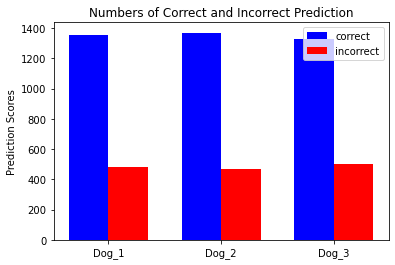

In [57]:
width = 0.35
labels = ['Dog_1', 'Dog_2', 'Dog_3']
correct = correct_breed.iloc[0].tolist()
incorrect = correct_breed.iloc[1].tolist()
x = np.arange(len(labels))

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, correct, width, label='correct',color='b')
rects2 = ax.bar(x + width/2, incorrect, width, label='incorrect', color='r')

ax.set_ylabel('Prediction Scores')
ax.set_title('Numbers of Correct and Incorrect Prediction')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend();

In [58]:
# Sum up the total number of correct and incorrect prediction and create a new column
correct_breed['total'] = correct_breed.sum(axis=1)
correct_breed

,dog_1,dog_2,dog_3,total
True,1353,1369,1330,4052
False,482,466,505,1453


In [59]:
# Percentage of correction
correct_breed.total[1]/ sum(correct_breed.total)

0.7360581289736603

The percentage of total correct prediction is 0.735, which is bases on the total amount of `True` under all 3 dog columns divided by the combined numbers of `True` and `False`. This mean there is a 3/4 chances of the image is correctly predicted by the Neural network.

In [60]:
tweet_analysis['dog_123'] = tweet_analysis['dog_1'] + tweet_analysis['dog_2'] + tweet_analysis['dog_3']
print("In about " + str(int(len(tweet_analysis[(tweet_analysis['dog_123']!=0) & (tweet_analysis['dog_123']!=3)])/len(tweet_analysis)*100)) + " percent of the cases, the picture ratings disagree about the rating of whether the picture is of a dog.")

In about 30 percent of the cases, the picture ratings disagree about the rating of whether the picture is of a dog.


In [61]:
tweet_analysis.loc[(tweet_analysis['dog_123']!=0) & (tweet_analysis['dog_123']!=3) & (~tweet_analysis['image_url'].isna()), 'image_url']

7         https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg
8         https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg
21        https://pbs.twimg.com/media/CT9OwFIWEAMuRje.jpg
32        https://pbs.twimg.com/media/CT-jNYqW4AAPi2M.jpg
33        https://pbs.twimg.com/media/CT-nsTQWEAEkyDn.jpg
                              ...                        
1983    https://pbs.twimg.com/ext_tw_video_thumb/88734...
1994      https://pbs.twimg.com/media/DFl99B1WsAITKsg.jpg
1999      https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg
2000      https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg
2002      https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
Name: image_url, Length: 437, dtype: object

#### 2. Which dog breed appeared the most according the prediction?

In [62]:
# Extract and combined the prediction columns into a new DataFrame then sorted out top 10 
breed = tweet_analysis[['prediction_1', 'prediction_2', 'prediction_3']].apply(pd.Series.value_counts)
breed['total'] = breed.sum(axis=1)
breed.sort_values('total', ascending=False, inplace=True)
breed = breed.head(10)
breed

,prediction_1,prediction_2,prediction_3,total
Labrador_retriever,83.00,85.00,68.00,236.00
Golden_retriever,118.00,69.00,43.00,230.00
Chihuahua,73.00,40.00,56.00,169.00
Pembroke,84.00,22.00,23.00,129.00
Cardigan,13.00,69.00,23.00,105.00
Toy_poodle,34.00,34.00,27.00,95.00
Pomeranian,35.00,34.00,24.00,93.00
Chow,37.00,20.00,27.00,84.00
Pug,52.00,16.00,14.00,82.00
French_bulldog,20.00,37.00,24.00,81.00


Text(0.5, 1.0, "Top 10 Predicted dog's breed")

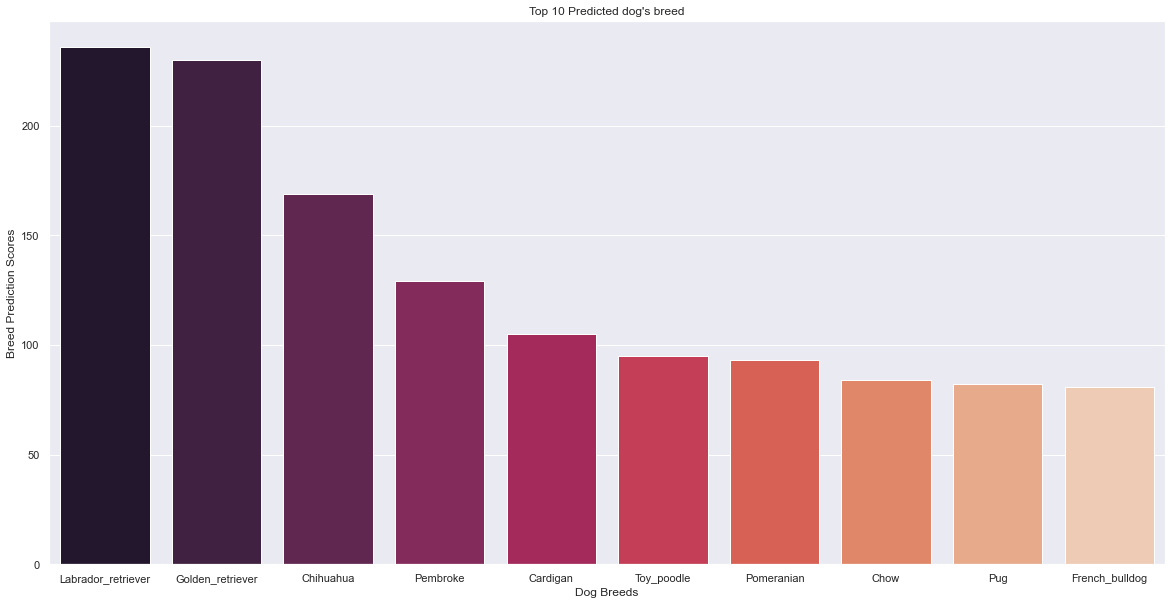

In [63]:
# Visualize bar chart top 10 predicted dog breed
x = breed.index.tolist()
y = breed.total.tolist()
sns.set(style='darkgrid')
plt.figure(figsize=(20,10));
sns.barplot(x=x, y=y, palette='rocket');
plt.xlabel('Dog Breeds')
plt.ylabel('Breed Prediction Scores')
plt.title("Top 10 Predicted dog's breed")

#### Summary
According to the prediction, the most predicted type of dog breed is Golden retriever. This make sense because Golden retrivever is very high energy and friendly type of breed, they are easy to train and very well behave, and their most distintive trait is their golden long fur coat.

#### 3. Which sources was used the most for tweeting?

In [64]:
# Using Value_counts to find values under source column and convert into dataframe
sources = pd.DataFrame(tweet_analysis.source.value_counts())
sources

,source
Twitter for iphone,1886
"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",79
Twitter Web Client,29
TweetDeck,10


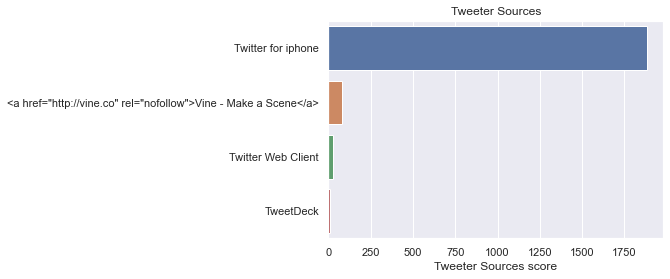

In [65]:
# plotting the sources score using barplot
sns.barplot(data=sources, x=sources['source'], y=sources.index);
plt.xlabel('Tweeter Sources score');
plt.title('Tweeter Sources');

Base on the barplot above, the most popular sources to sent tweets from is by using twitter iphone app. This make sense because mobile phone is much more convienece for usage to check news.

### Visualization
#### 1.  What are the relationship between retweet and favorites?

In [66]:
retweets_favorites = tweet_analysis[~tweet_analysis['favorite_count'].isna()]
retweets_favorites = retweets_favorites.astype({'retweet_count': 'int64', 'favorite_count': 'int64'})

In [67]:
retweets_favorites['favorite_count'].describe()

count     1,979.00
mean      6,519.95
std       9,565.65
min          45.00
25%       1,473.50
50%       3,074.00
75%       7,836.00
max     145,361.00
Name: favorite_count, dtype: float64

In [68]:
retweets_favorites['retweet_count'].describe()

count    1,979.00
mean     1,824.21
std      3,123.89
min          1.00
25%        454.50
50%        976.00
75%      2,136.00
max     71,132.00
Name: retweet_count, dtype: float64

In [69]:
data = retweets_favorites[['retweet_count', 'favorite_count']]
correlation = data.corr(method='pearson')
correlation

,retweet_count,favorite_count
retweet_count,1.00,0.92
favorite_count,0.92,1.00


In [70]:
tweet_analysis.query("favorite_count == 0")

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage,image_url,image_number,prediction_1,confidence_prediction_1,dog_1,prediction_2,confidence_prediction_2,dog_2,prediction_3,confidence_prediction_3,dog_3,retweet_count,favorite_count,dog_123


The correlation coefficient between retweet and favorites is 0.77. And there are 159 rows with zero favorites with high number of share. It's look like the favorites or like button was disabled.

C:\Users\marku\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


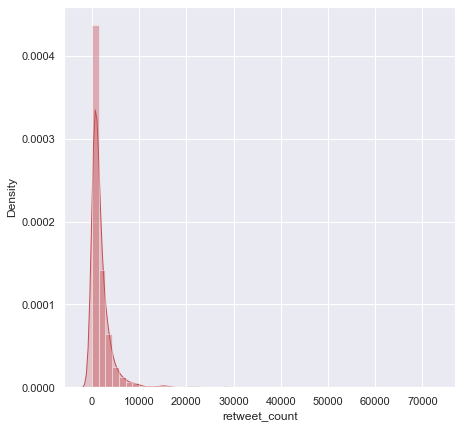

In [71]:
plt.subplots( figsize=(7, 7), sharex=True)
sns.distplot(retweets_favorites['retweet_count'], kde_kws={"shade":True}, color="r");

C:\Users\marku\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


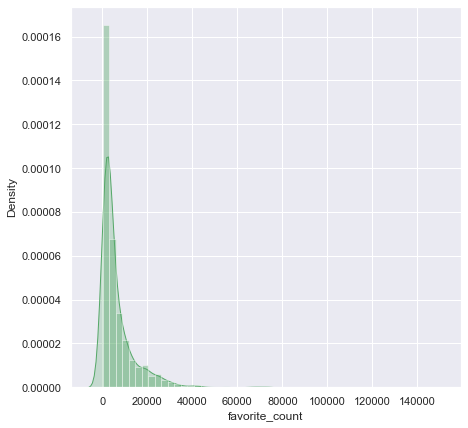

In [72]:
plt.subplots( figsize=(7, 7), sharex=True)
sns.distplot(retweets_favorites['favorite_count'], kde_kws={"shade":True}, color="g");

Both of the graph above are skewed to the right, which mean both show relation with each other.

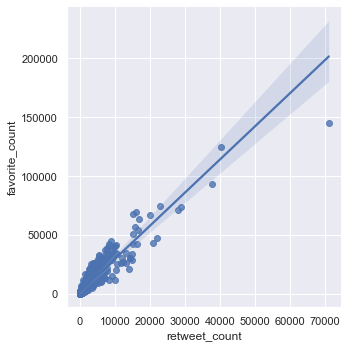

In [73]:
# Scatter plot and regression line of favorites and retweet
import seaborn as sns
sns.lmplot(x='retweet_count',y='favorite_count',data=retweets_favorites,fit_reg=True);

#### 4. How much was tweeted per day?

In [74]:
tweet_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2004 entries, 0 to 2003
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tweet_id                 2004 non-null   int64  
 1   timestamp                2004 non-null   object 
 2   source                   2004 non-null   object 
 3   text                     2004 non-null   object 
 4   expanded_urls            1946 non-null   object 
 5   rating_numerator         2004 non-null   int64  
 6   rating_denominator       2004 non-null   int64  
 7   name                     2004 non-null   object 
 8   doggo                    77 non-null     object 
 9   floofer                  10 non-null     object 
 10  pupper                   215 non-null    object 
 11  puppo                    20 non-null     object 
 12  stage                    2004 non-null   object 
 13  image_url                1835 non-null   object 
 14  image_number            

In [75]:
df_numbers = tweet_analysis[['timestamp', 'rating_numerator', 'rating_denominator', 'retweet_count', 'favorite_count']]
tweet_analysis = tweet_analysis.sort_values(by=['tweet_id'])
df = tweet_analysis.reset_index(drop=True)
df = df.reset_index()
df = df.astype({'timestamp': 'datetime64[ns]'})
test = df['timestamp'].dt.date.value_counts()

C:\Users\marku\AppData\Local\Temp/ipykernel_5044/203146617.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


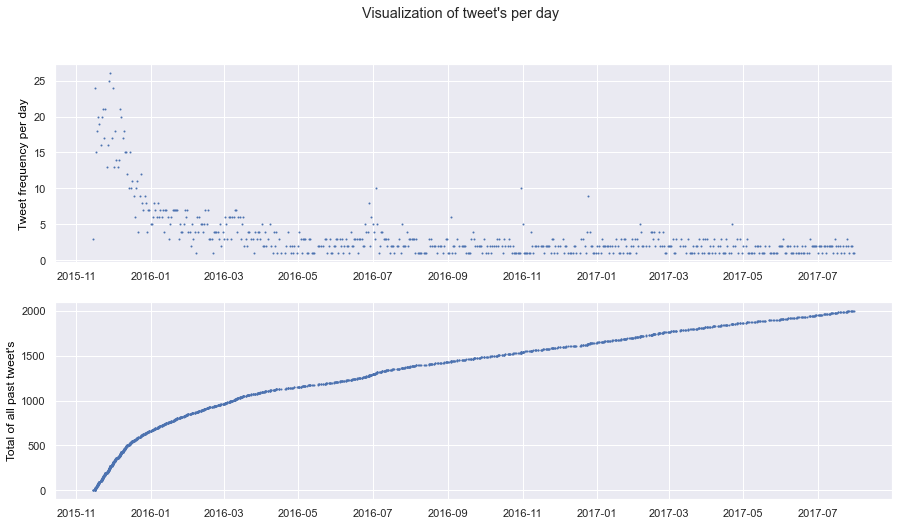

In [76]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,figsize=(15,8))
fig.suptitle("Visualization of tweet's per day")

axs[0].scatter(test.index, test, s=1)
axs[0].set_ylabel("Tweet frequency per day", color='black') 
axs[1].scatter(df['timestamp'].dt.date.tolist(), df['index'].tolist(), s=1)
axs[1].set_ylabel("Total of all past tweet's", color='black') 

fig.show()


If you look at the tweets per day and the sum of all tweets over time, you can see that there were significantly fewer tweets at the beginning of 2016. However, this amount of tweets is relatively constant for the rest of the time. Graphically evaluated, from August 2016 to August 2017 there were around 2 tweets per day.

## Conclusion
Base on the dataset, after cleaning, wrangling, analyzing, and visualizing. The important keys take away from this dataset are golden retreiver is either very popular dog breed or more accurately to predict by the neural network. The image prediction rates is approximately 73% correct. And Dogs with high favorites rating is also high have high number of retweets. 